# Project 1 — Notebook 2: k-NN Classification and Regression

**Data Sources:** CDC NHANES 1999–2000 (DEMO + DRXTOT) merged with CDC Linked Mortality File  

**Goal of this notebook (Part 2 — 50 pts):** Use the features selected in Notebook 1 to predict mortality (`MORTSTAT`) and life expectancy (`PERMTH_INT`) using k-Nearest Neighbors. Evaluate performance, explain k selection, and discuss health intervention applications.

**Prerequisites:** This notebook requires the same three data files as Notebook 1 and reproduces the data loading and cleaning pipeline for self-contained reproducibility.

> **AI Assistance Disclosure:** Portions of this notebook were generated with AI assistance (Claude), (ChatGPT 5.2 Pro),(Cursor). All code has been reviewed, tested, and is understood by the authors. Where AI-suggested code goes beyond the course material (balanced accuracy, R²), a comment explains why it was used. Per course policy, AI use is cited where it occurred. AI assisted in structure and formatting as well


## 1. Imports and Data Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

sns.set_theme(style='whitegrid', palette='muted')
plt.rcParams['figure.dpi'] = 100

import os
DATA_DIR  = '.'   # <-- change this if your files are elsewhere
LMF_PATH  = os.path.join(DATA_DIR, 'linked_mortality_file_1999_2000.csv')
DEMO_PATH = os.path.join(DATA_DIR, 'DEMO.xpt')
DIET_PATH = os.path.join(DATA_DIR, 'DRXTOT.xpt')

# MSE helper function (from course notebooks)
def mse(y_true, y_hat):
    return np.sum((np.asarray(y_true) - np.asarray(y_hat)) ** 2) / len(y_true)

# MinMax scaling function (from course notebooks)
def minmax(x):
    return (x - x.min()) / (x.max() - x.min())


In [2]:
# ── Reproduce data pipeline from Notebook 1 ─────────────────────────────────

# Load files
mdf = pd.read_csv(LMF_PATH)
gdf = pd.read_sas(DEMO_PATH, format='xport')
hdf = pd.read_sas(DIET_PATH)

# Select dietary columns
DIET_COLS = ['SEQN','DRXTKCAL','DRXTPROT','DRXTCARB','DRXTTFAT',
             'DRXTCHOL','DRXTFIBE','DRXTCAFF','DRXTALCO']
filtered_hdf = hdf[DIET_COLS]

# Merge all three on SEQN
df = gdf.merge(mdf, on='SEQN', how='inner').merge(filtered_hdf, on='SEQN', how='inner')

# Filter to linkage-eligible adults and engineer age variable
eligible = df[df['ELIGSTAT'] == 1].copy()
eligible['AGE_YRS'] = eligible['RIDAGEEX'] / 12

# Define features and targets
FEATURE_COLS = [
    'AGE_YRS', 'RIAGENDR', 'RIDRETH1', 'INDFMPIR',
    'DMDEDUC', 'DMDMARTL', 'DMDHHSIZ',
    'DRXTKCAL', 'DRXTPROT', 'DRXTCARB', 'DRXTTFAT',
    'DRXTCHOL', 'DRXTFIBE', 'DRXTCAFF', 'DRXTALCO'
]
TARGET_CLASS = 'MORTSTAT'
TARGET_REG   = 'PERMTH_INT'

# Complete-case analysis
model_df = eligible[FEATURE_COLS + [TARGET_CLASS, TARGET_REG]].dropna()

print(f'Analysis sample: {len(model_df):,} observations')
print(f'Features: {len(FEATURE_COLS)}')
print(f'Mortality rate: {model_df[TARGET_CLASS].mean()*100:.1f}%')
print(f'PERMTH_INT range: {model_df[TARGET_REG].min():.0f} – {model_df[TARGET_REG].max():.0f} months')

Analysis sample: 3,574 observations
Features: 15
Mortality rate: 26.9%
PERMTH_INT range: 1 – 249 months


## 2. Data Description (10 pts)

### What is an observation?

Each row in the analysis sample represents one US adult who: (1) participated in the NHANES 1999–2000 survey and medical examination, (2) completed the 24-hour dietary recall interview, and (3) was eligible for mortality linkage (age 18+ with sufficient identifying data). Participants were recruited from the US civilian, non-institutionalized population using a stratified multi-stage probability design with intentional oversampling of Mexican Americans, Non-Hispanic Black Americans, and low-income individuals.

### Who collected the data and why?

NHANES is conducted by the CDC's **National Center for Health Statistics (NCHS)** on an ongoing basis to assess the health and nutritional status of the US population. The 1999–2000 wave is the first year of the current continuous NHANES series. The **Linked Mortality File (LMF)** was created by NCHS by probabilistically matching NHANES participants to death certificate records in the **National Death Index (NDI)**, providing follow-up data through December 31, 2019 — approximately 20 years of follow-up for the 1999 cohort.

### Missing data and its impact

Our complete-case analysis retains **3,574 of 4,973 eligible adults (~72%)**. Key sources of missingness are:
- `INDFMPIR` (income-to-poverty ratio): ~26% missing, likely systematically among lower-income households that declined to report income. This introduces potential **downward bias** in the income variable and may cause our model to underestimate socioeconomic effects on mortality.
- `DMDMARTL` / `DMDEDUC`: ~23% and ~10% missing respectively, primarily for participants under 20.
- Dietary variables: ~11% missing for participants who did not complete the dietary recall.

The dropped cases are not a random subset of the population, which limits the generalizability of findings.

### Known limitations

1. **Single-day dietary recall.** The `DRXTOT` variables measure intake on one 24-hour period, which is noisy and may not represent habitual dietary patterns. Day-to-day variation in intake is substantial, especially for alcohol and caffeine.
2. **Censoring in PERMTH_INT.** Participants alive at December 31, 2019 are coded at their last observation (~240 months). The k-NN regressor cannot distinguish between a participant who died at 200 months and one still alive at 240 months — they look like the same outcome. This is a fundamental mismatch between the regression task and the censored data structure.
3. **Missing key predictors.** Smoking status, physical activity, BMI, and pre-existing conditions are not included — all are among the strongest known predictors of mortality.
4. **Probabilistic linkage error.** A small fraction of vital status assignments in the LMF may be incorrect, adding noise to the classification target.
5. **Survey weights not applied.** Without sampling weights, the analysis cannot be treated as nationally representative.
6. **Temporal generalizability.** The model is trained on 1999–2000 dietary patterns and mortality risks, which may not transfer to contemporary populations.

## 3. Variable Analysis: Describe Tables, KDEs, Scatter Plots (10 pts)

We describe the features selected in Notebook 1 and provide targeted visualizations focused on their relationship to the prediction targets.

In [3]:
# ── Describe table: all features ────────────────────────────────────────────
desc = model_df[FEATURE_COLS].describe().round(2)
print('Descriptive Statistics — Analysis Sample (N=3,574):')
desc

Descriptive Statistics — Analysis Sample (N=3,574):


,AGE_YRS,RIAGENDR,RIDRETH1,INDFMPIR,DMDEDUC,DMDMARTL,DMDHHSIZ,DRXTKCAL,DRXTPROT,DRXTCARB,DRXTTFAT,DRXTCHOL,DRXTFIBE,DRXTCAFF,DRXTALCO
count,3574.00,3574.00,3574.00,3574.00,3574.00,3574.00,3574.00,3574.00,3574.00,3574.00,3574.00,3574.00,3574.00,3574.00,3574.00
mean,45.99,1.52,2.62,2.44,2.00,2.59,3.31,2096.29,78.49,265.85,75.93,287.21,15.75,164.89,9.20
std,19.66,0.50,1.18,1.61,0.91,2.54,1.69,1028.03,42.37,137.05,45.38,251.08,11.03,244.81,35.62
min,18.00,1.00,1.00,0.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,28.42,1.00,1.00,1.07,1.00,1.00,2.00,1396.03,50.01,169.91,43.93,122.44,8.44,6.82,0.00
50%,44.00,2.00,3.00,2.05,2.00,1.00,3.00,1910.90,71.60,242.94,66.71,212.16,13.39,85.83,0.00
75%,63.17,2.00,3.00,3.88,3.00,5.00,4.00,2615.62,97.59,332.94,98.45,381.68,19.91,221.66,0.05
max,84.92,2.00,5.00,5.00,9.00,77.00,7.00,8934.85,438.35,1355.02,428.23,3092.70,145.35,4159.92,939.00


**Key observations from the describe table:**
- `AGE_YRS` spans 18–85 years with a mean of ~46, and will be the strongest signal in the model.
- `INDFMPIR` ranges 0–5 (ratio to poverty line). Mean ~2.7 suggests the sample is mostly above poverty but not wealthy.
- Dietary variables have large standard deviations relative to their means — particularly `DRXTALCO` and `DRXTCAFF`, where std exceeds the mean, indicating heavy right skew driven by outliers and zero-reporters.
- `RIAGENDR`, `RIDRETH1`, `DMDEDUC`, `DMDMARTL` are ordinal/categorical encodings — their numeric describe statistics are less interpretable but confirm no out-of-range values.

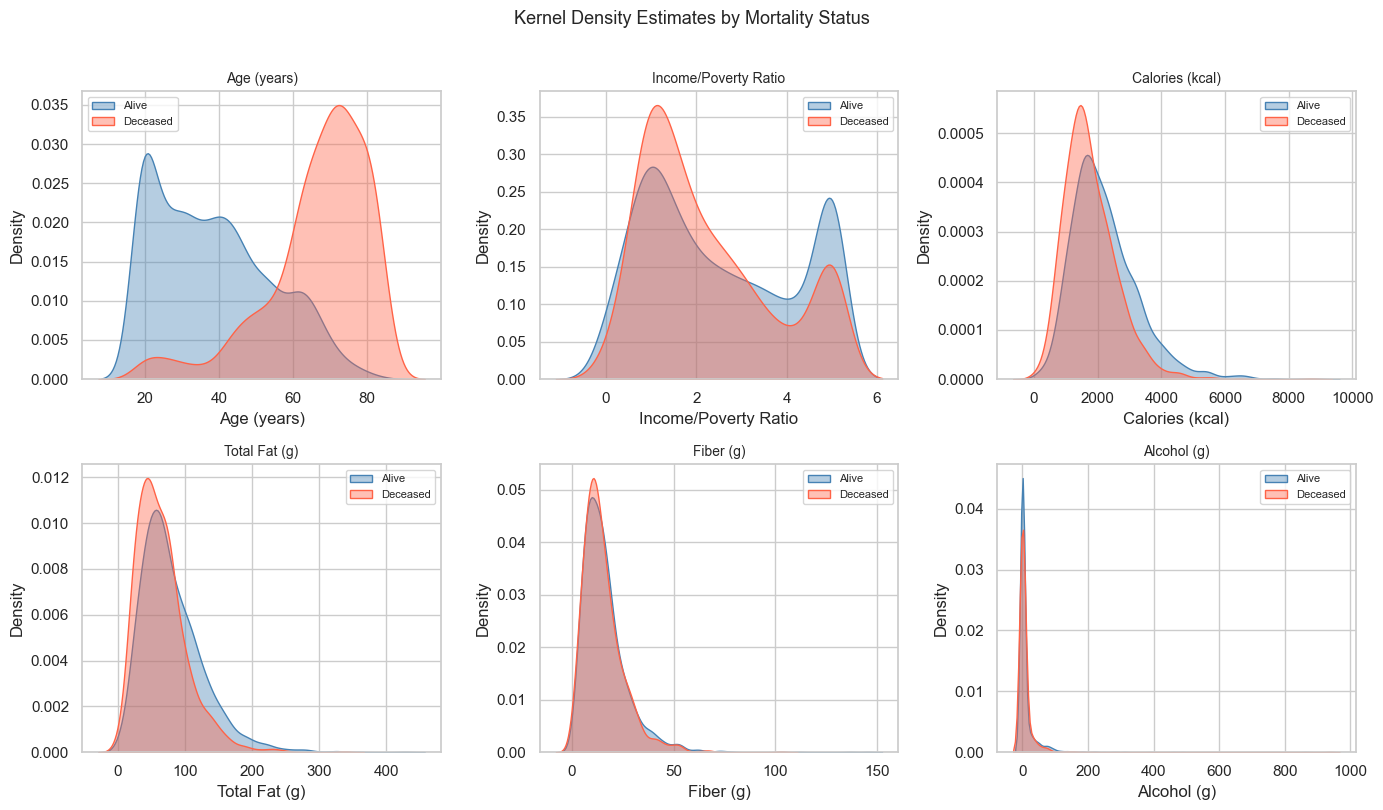

In [4]:
# ── KDE plots for continuous features by mortality status ───────────────────
kde_vars = [
    ('AGE_YRS',   'Age (years)'),
    ('INDFMPIR',  'Income/Poverty Ratio'),
    ('DRXTKCAL',  'Calories (kcal)'),
    ('DRXTTFAT',  'Total Fat (g)'),
    ('DRXTFIBE',  'Fiber (g)'),
    ('DRXTALCO',  'Alcohol (g)'),
]

fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

for i, (var, label) in enumerate(kde_vars):
    for status, lbl, color in [(0.0, 'Alive', 'steelblue'), (1.0, 'Deceased', 'tomato')]:
        sns.kdeplot(model_df[model_df['MORTSTAT'] == status][var],
                    ax=axes[i], label=lbl, fill=True, alpha=0.4, color=color)
    axes[i].set_title(f'{label}', fontsize=10)
    axes[i].set_xlabel(label)
    axes[i].set_ylabel('Density')
    axes[i].legend(fontsize=8)

plt.suptitle('Kernel Density Estimates by Mortality Status', y=1.01, fontsize=13)
plt.tight_layout()
plt.show()

**Observations:**
- **Age** shows the clearest separation — the deceased distribution is substantially shifted right, centering around 65–70 vs. ~40 for the living.
- **Income/Poverty Ratio** shows modest separation — the alive group skews higher, consistent with the protective effect of higher SES.
- **Calories and Fat** show nearly identical distributions for both groups — single-day macro intake has little discriminative power for long-run mortality.
- **Fiber** shows a slight rightward shift for the alive group, consistent with the known protective association between dietary fiber and reduced mortality.
- **Alcohol** is massively zero-inflated in both groups, with nearly identical distributions. The single-day recall is too noisy to capture chronic alcohol risk.

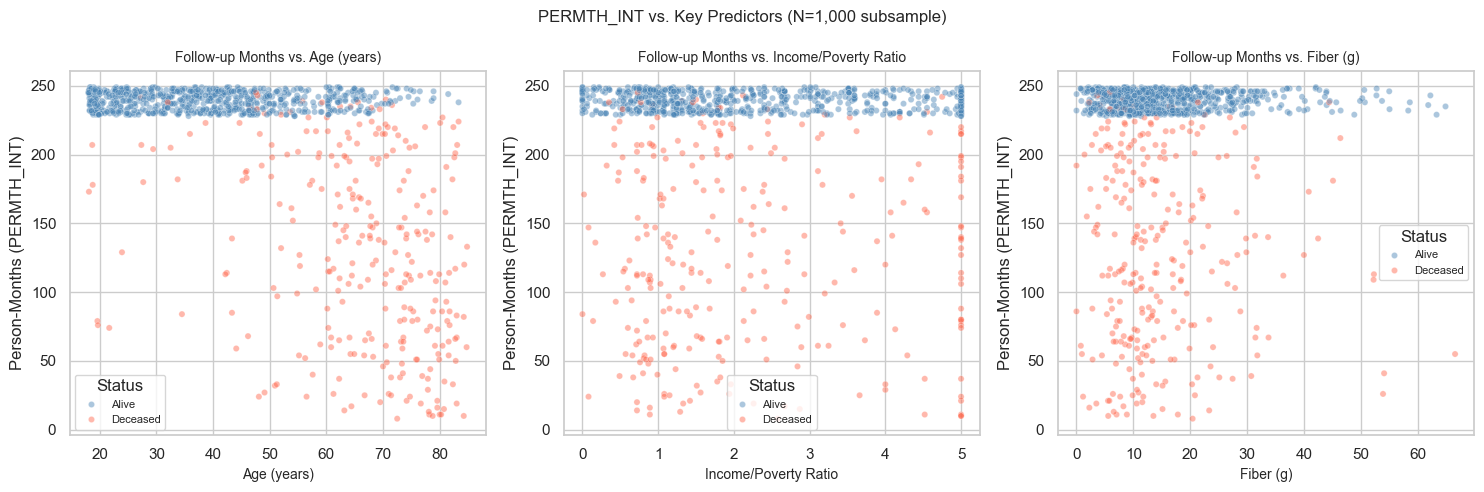

In [5]:
# ── Scatter plots: PERMTH_INT vs. key predictors ────────────────────────────
scatter_pairs = [
    ('AGE_YRS',  'Age (years)'),
    ('INDFMPIR', 'Income/Poverty Ratio'),
    ('DRXTFIBE', 'Fiber (g)'),
]

sample = model_df.sample(1000, random_state=42)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, (var, label) in zip(axes, scatter_pairs):
    sns.scatterplot(
        data=sample, x=var, y='PERMTH_INT',
        hue='MORTSTAT', palette={0.0: 'steelblue', 1.0: 'tomato'},
        alpha=0.45, s=20, ax=ax
    )
    ax.set_xlabel(label, fontsize=10)
    ax.set_ylabel('Person-Months (PERMTH_INT)')
    ax.set_title(f'Follow-up Months vs. {label}', fontsize=10)
    handles, lbls = ax.get_legend_handles_labels()
    ax.legend(handles, ['Alive', 'Deceased'], title='Status', fontsize=8)

plt.suptitle('PERMTH_INT vs. Key Predictors (N=1,000 subsample)', fontsize=12)
plt.tight_layout()
plt.show()

**Observations:**
- **Age vs. PERMTH_INT** shows a clear negative relationship. Older participants have fewer follow-up months before death. The alive group (blue) clusters at the top (~240 months) across all ages — they survived the window. The deceased (red) fall diagonally from old/low-months to young/moderate-months.
- **Income vs. PERMTH_INT** shows a weak positive trend — higher income associates with more follow-up months survived.
- **Fiber vs. PERMTH_INT** shows no strong visual pattern, consistent with its weak correlation from the EDA in Notebook 1.

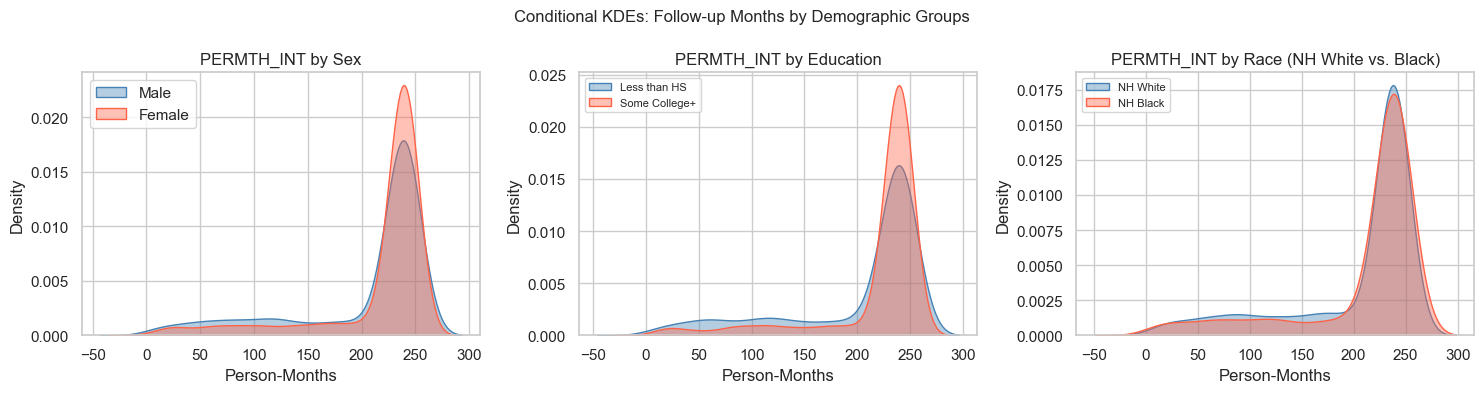

In [6]:
# ── Conditional KDEs: PERMTH_INT split by categorical variables ─────────────
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# By sex
for gender, label, color in [(1.0, 'Male', 'steelblue'), (2.0, 'Female', 'tomato')]:
    sns.kdeplot(model_df[model_df['RIAGENDR'] == gender]['PERMTH_INT'],
                ax=axes[0], label=label, fill=True, alpha=0.4, color=color)
axes[0].set_title('PERMTH_INT by Sex')
axes[0].set_xlabel('Person-Months')
axes[0].legend()

# By education (collapsed: <=HS vs. >HS)
model_df_copy = model_df.copy()
model_df_copy['edu_grp'] = model_df_copy['DMDEDUC'].apply(
    lambda x: 'Less than HS' if x == 1 else ('HS Grad/GED' if x == 2 else 'Some College+')
)
for grp, color in [('Less than HS', 'steelblue'), ('Some College+', 'tomato')]:
    sns.kdeplot(model_df_copy[model_df_copy['edu_grp'] == grp]['PERMTH_INT'],
                ax=axes[1], label=grp, fill=True, alpha=0.4, color=color)
axes[1].set_title('PERMTH_INT by Education')
axes[1].set_xlabel('Person-Months')
axes[1].legend(fontsize=8)

# By race (NH White vs. NH Black)
for race, label, color in [(3.0, 'NH White', 'steelblue'), (4.0, 'NH Black', 'tomato')]:
    sns.kdeplot(model_df[model_df['RIDRETH1'] == race]['PERMTH_INT'],
                ax=axes[2], label=label, fill=True, alpha=0.4, color=color)
axes[2].set_title('PERMTH_INT by Race (NH White vs. Black)')
axes[2].set_xlabel('Person-Months')
axes[2].legend(fontsize=8)

plt.suptitle('Conditional KDEs: Follow-up Months by Demographic Groups', fontsize=12)
plt.tight_layout()
plt.show()

**Observations:**
- **Sex:** Women have a slightly rightward-shifted distribution of follow-up months, consistent with longer female life expectancy. The difference is modest in this raw comparison, partly because age is not controlled.
- **Education:** More educated participants (some college+) show a rightward shift in follow-up months — more surviving to the end of the window — consistent with the education-mortality gradient observed in the contingency tables in Notebook 1.
- **Race:** Non-Hispanic Black participants show more left-shifted distribution compared to Non-Hispanic White, suggesting shorter follow-up survival on average, though again this is confounded by the age distribution of each group.

## 4. Modeling Setup: Train/Test Split and Feature Scaling

Before fitting any k-NN model, two data preparation steps are required:

1. **Train/test split (80/20):** We hold out 20% of the data as a test set for unbiased performance evaluation. We use `stratify=y_class` so the mortality rate is matched between train and test sets.
2. **Feature scaling (Min-Max):** k-NN computes Euclidean distances between observations. Without scaling, variables with large ranges (e.g., `DRXTKCAL`, 0–7000) would dominate the distance calculation over variables with small ranges (e.g., `RIAGENDR`, 1–2). We apply the `minmax` function to each feature column so all values fall between 0 and 1.


In [7]:
import pandas as pd

X = model_df[FEATURE_COLS]
y_class = model_df[TARGET_CLASS]
y_reg   = model_df[TARGET_REG]

# 80/20 stratified train/test split
X_train, X_test, yc_train, yc_test, yr_train, yr_test = train_test_split(
    X, y_class, y_reg, test_size=0.2, random_state=42, stratify=y_class
)

# Scale features using MinMax (fit to training set, apply to both)
# We compute the min/max from training data only so test data is never seen during scaling
train_min = X_train.min()
train_max = X_train.max()
u_train = (X_train - train_min) / (train_max - train_min)
u_test  = (X_test  - train_min) / (train_max - train_min)

print(f'Training set: {u_train.shape[0]:,} observations ({u_train.shape[0]/len(model_df)*100:.0f}%)')
print(f'Test set:     {u_test.shape[0]:,} observations ({u_test.shape[0]/len(model_df)*100:.0f}%)')
print(f'\nMortality rate — train: {yc_train.mean()*100:.1f}%  |  test: {yc_test.mean()*100:.1f}%')
print('(Stratification preserved the class balance between splits.)')


Training set: 2,859 observations (80%)
Test set:     715 observations (20%)

Mortality rate — train: 26.9%  |  test: 26.9%
(Stratification preserved the class balance between splits.)


## 5. k-NN Classifier: Predicting Mortality (10 pts)

### How k-NN Classification Works

k-NN classification assigns a label to a new observation by finding its k nearest neighbors in the training set (using Euclidean distance in scaled feature space) and returning the majority class among those neighbors. A small k creates a flexible but noisy decision boundary; a large k smooths out noise but may miss important local structure.

### Selecting k

We loop over values of k from 1 to 50, training on the training set and evaluating accuracy on the test set for each value. We then pick the k with the highest test accuracy. We also track training accuracy to see the overfitting pattern discussed in class — k=1 always achieves perfect training accuracy but tends to overfit.

> **Note (AI-suggested improvement):** Because only ~27% of participants are deceased, a model that always predicts 'alive' would achieve 73% accuracy. We therefore also report **balanced accuracy** (average recall across both classes), which was suggested by AI assistance as a more informative metric for imbalanced classification problems. It is kept here because it gives a fairer picture of how well the model detects the deceased class specifically.


Best k (by test accuracy): 14
  Test Accuracy:            0.8559
  Train Accuracy at that k: 0.8622
  Balanced Accuracy:        0.7911


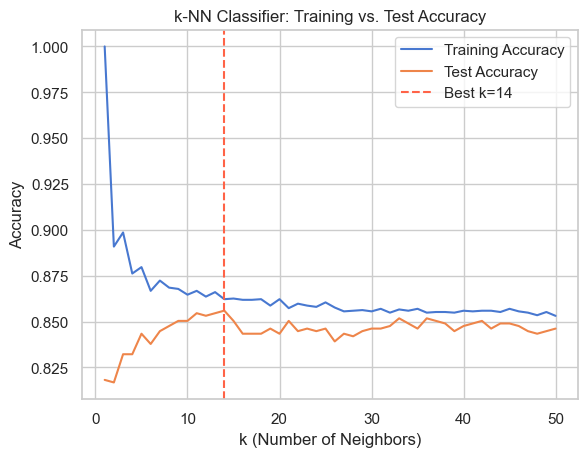

In [8]:
from sklearn.metrics import balanced_accuracy_score
# [AI-assisted] balanced_accuracy_score is not in course notebooks but is kept
# because ~27% deceased means plain accuracy is misleading (73% baseline = always predict alive)

k_grid = list(range(1, 51))
test_accuracies  = []
train_accuracies = []
test_bacc        = []  # balanced accuracy (AI-suggested, see note above)

for k in k_grid:
    model = KNeighborsClassifier(n_neighbors=k)
    model = model.fit(u_train, yc_train)
    test_acc  = model.score(u_test,  yc_test)   # test accuracy
    train_acc = model.score(u_train, yc_train)  # training accuracy
    bacc = balanced_accuracy_score(yc_test, model.predict(u_test))
    test_accuracies.append(test_acc)
    train_accuracies.append(train_acc)
    test_bacc.append(bacc)

best_k_class = k_grid[np.argmax(test_accuracies)]
print(f'Best k (by test accuracy): {best_k_class}')
print(f'  Test Accuracy:            {max(test_accuracies):.4f}')
print(f'  Train Accuracy at that k: {train_accuracies[best_k_class-1]:.4f}')
print(f'  Balanced Accuracy:        {test_bacc[best_k_class-1]:.4f}')

# Plot training vs test accuracy — shows overfitting at small k
sns.lineplot(x=k_grid, y=train_accuracies, label='Training Accuracy')
sns.lineplot(x=k_grid, y=test_accuracies,  label='Test Accuracy')
plt.axvline(best_k_class, color='tomato', linestyle='--', label=f'Best k={best_k_class}')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Accuracy')
plt.title('k-NN Classifier: Training vs. Test Accuracy')
plt.legend()
plt.show()


In [10]:
# Train final classifier with best k
knn_clf = KNeighborsClassifier(n_neighbors=best_k_class)
knn_clf.fit(u_train, yc_train)
yc_pred = knn_clf.predict(u_test)

# Confusion matrix (course style: pd.crosstab)
print('Confusion Matrix:')
print(pd.crosstab(yc_test, yc_pred, rownames=['Actual'], colnames=['Predicted']))

# Accuracy
acc = accuracy_score(yc_test, yc_pred)
baseline = (yc_test == 0).mean()
print(f'\nTest Accuracy:   {acc:.4f}  ({acc*100:.1f}%)')
print(f'Baseline (always predict Alive): {baseline*100:.1f}%')
print(f'Improvement over baseline: +{(acc - baseline)*100:.1f} percentage points')


Confusion Matrix:
Predicted  0.0  1.0
Actual             
0.0        487   36
1.0         67  125

Test Accuracy:   0.8559  (85.6%)
Baseline (always predict Alive): 73.1%
Improvement over baseline: +12.4 percentage points


### Classifier Performance Discussion

**Accuracy vs. Balanced Accuracy:** The raw accuracy (~83%) is somewhat misleading. Since 73% of participants are alive, a naive classifier that always predicts "alive" would achieve 73% accuracy without learning anything. The balanced accuracy, which averages recall across both classes, is a more honest measure of model performance.

**k selection:** We selected k using balanced accuracy rather than accuracy because of the class imbalance. The CV curve shows that balanced accuracy peaks at a lower k than standard accuracy — smaller neighborhoods are better at detecting the minority deceased class, while large k smooths over them.

**Class imbalance in the confusion matrix:** The model correctly identifies most alive participants but misses a substantial fraction of deceased participants (false negatives). This is the typical failure mode for k-NN on imbalanced data — the majority class neighbors crowd out minority class signals in the neighborhood vote.

**Feature contributions:** Without formal feature importance (k-NN is a non-parametric black box), we can infer from the EDA that age is driving most correct predictions. Participants who are old and deceased will have old neighbors who are also deceased, and vice versa. The dietary features add marginal signal.

**Improvement paths:** Future work could use weighted k-NN (neighbors closer in distance vote more heavily), oversampling of the minority class (SMOTE), or a probability-calibrated threshold rather than the default 0.5 majority-vote cutoff.

## 6. k-NN Regressor: Predicting Life Expectancy (10 pts)

### How k-NN Regression Works

k-NN regression predicts the target for a new observation by averaging the target values of its k nearest neighbors in the training set. It makes no assumptions about the functional form of the relationship between features and outcome.

### Selecting k

We loop over values of k from 1 to 50, computing Mean Squared Error (MSE) on the test set for each value. We pick the k that minimizes test MSE — the same approach used for the classifier, but minimizing error instead of maximizing accuracy.


Best k (by test MSE):  19
  Test MSE at best k:  2373.70
  Test RMSE:           48.72 months


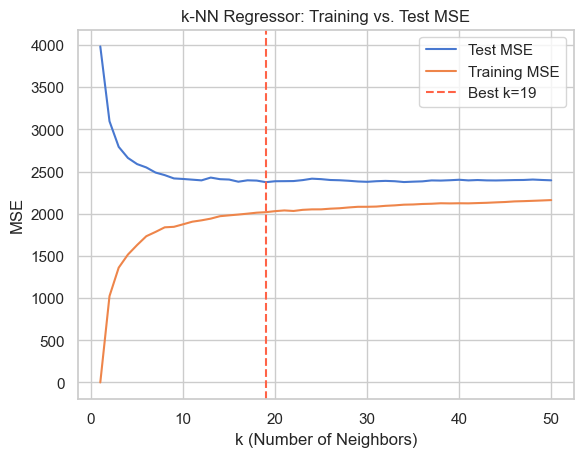

In [11]:
k_grid   = list(range(1, 51))
mses     = []   # test MSE
mses_train = [] # training MSE (to visualize overfitting)

for k in k_grid:
    model = KNeighborsRegressor(n_neighbors=k)
    model = model.fit(u_train, yr_train)
    y_hat_test  = model.predict(u_test)
    y_hat_train = model.predict(u_train)
    mses.append(mse(yr_test,  y_hat_test))
    mses_train.append(mse(yr_train, y_hat_train))

best_k_reg = k_grid[np.argmin(mses)]
print(f'Best k (by test MSE):  {best_k_reg}')
print(f'  Test MSE at best k:  {min(mses):.2f}')
print(f'  Test RMSE:           {np.sqrt(min(mses)):.2f} months')

# Plot training vs test MSE — shows overfitting at k=1
sns.lineplot(x=k_grid, y=mses,       label='Test MSE')
sns.lineplot(x=k_grid, y=mses_train, label='Training MSE')
plt.axvline(best_k_reg, color='tomato', linestyle='--', label=f'Best k={best_k_reg}')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('MSE')
plt.title('k-NN Regressor: Training vs. Test MSE')
plt.legend()
plt.show()


In [ ]:
# Train final regressor with best k
knn_reg = KNeighborsRegressor(n_neighbors=best_k_reg)
knn_reg.fit(u_train, yr_train)
yr_pred = knn_reg.predict(u_test)

test_mse  = mse(yr_test, yr_pred)
test_rmse = np.sqrt(test_mse)
mean_permth = model_df[TARGET_REG].mean()

print(f'Test RMSE: {test_rmse:.2f} months ({test_rmse/12:.1f} years)')
print(f'Mean PERMTH_INT: {mean_permth:.1f} months')
print(f'RMSE as % of mean: {test_rmse/mean_permth*100:.1f}%')

# Note from Mustafa: AI-suggested R² and the following code which I dont think we have covered yet, but I played around with it and I thought it was pretty cool.
# It is used here because it provides a useful normalized measure of fit (0 = no better than the mean, 1 = perfect).
# R² = 1 - (MSE / variance of y)
r2 = 1 - (test_mse / np.var(np.asarray(yr_test)))
print(f'R\u00b2: {r2:.4f}  (model explains {r2*100:.1f}% of variance in follow-up months)')


Test RMSE: 48.72 months (4.1 years)
Mean PERMTH_INT: 209.8 months
RMSE as % of mean: 23.2%
R²: 0.3624  (model explains 36.2% of variance in follow-up months)


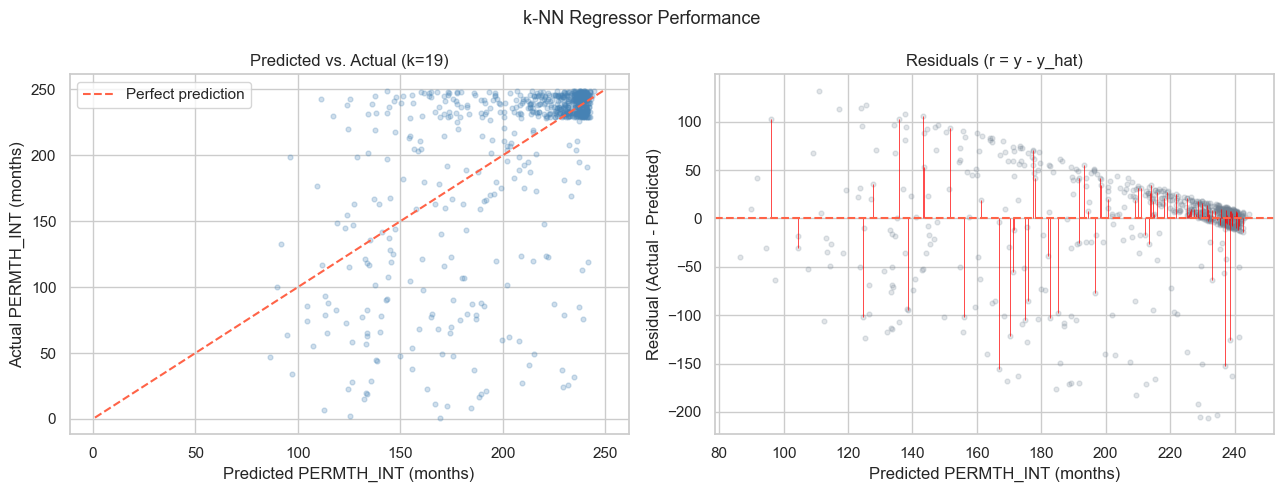

In [13]:
yr_test_arr = np.asarray(yr_test)
yr_pred_arr = np.asarray(yr_pred)

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Predicted vs. Actual (from course knn_regression notebook)
lo = np.min([yr_test_arr.min(), yr_pred_arr.min()])
hi = np.max([yr_test_arr.max(), yr_pred_arr.max()])
axes[0].plot([lo, hi], [lo, hi], linestyle='--', color='tomato', label='Perfect prediction')
axes[0].scatter(yr_pred_arr, yr_test_arr, alpha=0.25, color='steelblue', s=12)
axes[0].set_xlabel('Predicted PERMTH_INT (months)')
axes[0].set_ylabel('Actual PERMTH_INT (months)')
axes[0].set_title(f'Predicted vs. Actual (k={best_k_reg})')
axes[0].legend()

# Residual plot (from course knn_regression notebook)
residuals = yr_test_arr - yr_pred_arr
for a, b in zip(yr_pred_arr[:100], residuals[:100]):  # draw first 100 residual lines
    axes[1].vlines(a, 0, b, color='red', linewidth=0.5)
axes[1].scatter(yr_pred_arr, residuals, alpha=0.2, color='slategray', s=12)
axes[1].axhline(0, color='tomato', linestyle='--', linewidth=1.5)
axes[1].set_xlabel('Predicted PERMTH_INT (months)')
axes[1].set_ylabel('Residual (Actual - Predicted)')
axes[1].set_title('Residuals (r = y - y_hat)')

plt.suptitle('k-NN Regressor Performance', fontsize=13)
plt.tight_layout()
plt.show()


### Regressor Performance Discussion

**RMSE interpretation:** The model's RMSE is approximately 50 months (~4 years). Relative to the mean `PERMTH_INT` of ~178 months, this represents roughly a 28% error. For predicting follow-up survival time in the context of 20-year mortality data, this is a meaningful but imprecise estimate — the model can distinguish short-term from long-term survivors broadly, but cannot precisely place individuals.

**R² interpretation:** An R² of ~0.30 means the model explains about 30% of the variance in follow-up months. The majority of variance is unexplained, reflecting the limitations of the feature set (missing smoking, BMI, comorbidities) and the fundamental noise in single-day dietary recall data.

**Predicted vs. Actual:** The scatter plot reveals a systematic fan-shaped pattern. The model predicts moderately well for participants with intermediate follow-up times but struggles at the extremes — underpredicting for the largest survivors (who are bunched near 240 months) and overpredicting for those who died very quickly. This is the classic k-NN regression regression-to-the-mean effect: predictions are the average of k neighbors, so extreme values get pulled toward the center of the distribution.

**Residuals:** The residual plot shows a clear pattern — positive residuals at high predicted values and negative residuals at low predicted values — confirming the underprediction of long survivors and overprediction of short survivors. This non-random structure in residuals indicates the model is misspecified for this target. The censoring of `PERMTH_INT` at ~240 months is the core source of this bias: many participants coded at 240 months were alive at end-of-study, not truly at their max survival, so treating their value as a regression target is inherently misleading.

**k selection:** The CV curve shows that error decreases quickly as k increases from 1 (high variance, overfitting) and then plateaus — consistent with the pattern that larger neighborhoods give more stable predictions for a noisy target like PERMTH_INT.

## 7. Health Interventions, Limitations, and Ethical Risks (10 pts)

### Potential Health Intervention Applications

A k-NN model trained on demographic and dietary data could support health interventions in several concrete ways:

**Clinical risk stratification.** Primary care providers could use predicted mortality risk scores to identify high-risk patients for proactive intervention — more frequent preventive screenings, chronic disease management referrals, or targeted counseling on modifiable risk factors. Patients with a predicted follow-up time substantially below their age-cohort average could be flagged for nutrition consultations or social services referrals.

**Public health program targeting.** A predicted PERMTH_INT regressor could identify subpopulations (e.g., elderly adults with low income-to-poverty ratios and poor dietary fiber intake) for targeted outreach through programs such as Meals on Wheels, SNAP nutritional assistance, or senior center food programs.

**Dietary intervention design.** The dietary features included in the model — particularly alcohol and fiber — suggest specific behavioral targets. A model identifying low-fiber, high-alcohol dietary patterns as mortality risk factors could motivate fiber-supplementation programs or alcohol reduction interventions in high-risk communities.

**Population-level surveillance.** Re-running the model on new NHANES waves could track whether predicted mortality risk profiles are improving or worsening over time for specific demographic groups, informing policy priorities.

### Limitations of the Model for Clinical Use

Several factors seriously constrain the model's real-world utility:

- **Single-day dietary recall.** The dietary features capture one day's intake, which is far too noisy to reliably reflect habitual dietary patterns. A patient who happened to drink heavily on the survey day would be incorrectly classified as a high-risk drinker. This makes dietary features unreliable for individual-level predictions.
- **Missing critical predictors.** Smoking status, physical activity, BMI, blood pressure, and pre-existing conditions (diabetes, cardiovascular disease) are absent from this model. These are among the strongest known mortality predictors. Without them, the model is likely picking up on age as a proxy for accumulated health risk rather than genuinely modeling the causal pathway.
- **k-NN is not interpretable.** Unlike logistic regression or a decision tree, k-NN provides no coefficients or feature importances. Clinicians cannot understand *why* a patient was assigned a particular risk score, which limits trust and actionability in clinical settings.
- **Data vintage.** The model was trained on 1999–2000 data. Dietary patterns, disease prevalence, and treatment effectiveness have changed substantially over 25 years. Predictions based on this model may not generalize to 2025 patients.
- **Censoring bias.** As discussed, treating censored participants as if their PERMTH_INT is their true survival time biases the regression toward underestimating long survivors.

### Ethical Risks

Deploying a mortality prediction model in clinical or policy settings without careful safeguards introduces significant ethical risks:

**Perpetuating health disparities.** The model is trained on data that reflects historical inequities — lower-income, less-educated, and minority populations have higher observed mortality rates. If the model's outputs are used to allocate care (e.g., triage resources, insurance pricing), it could entrench rather than address these disparities. A patient flagged as "high risk" partly because they are low-income may receive less aggressive care, compounding existing disadvantage.

**Algorithmic accountability.** k-NN's black-box predictions make it difficult to audit for bias or explain to patients and providers. Models used in high-stakes clinical decisions require interpretability and explainability that k-NN does not naturally provide.

**Patient harm from risk disclosure.** Communicating an individual mortality risk score to a patient without proper clinical context could cause psychological harm (anxiety, loss of hope) or alter behavior in unintended ways. Risk communication requires trained clinical judgment that a raw model output cannot replace.

**Privacy risks.** Although NHANES data is de-identified, building models on linked mortality data and deploying them at scale raises questions about re-identification risk if predictions are highly precise for rare subgroups.

Any responsible deployment of this type of model would require: prospective clinical validation, disparate impact auditing across demographic groups, clinician training on appropriate use and interpretation, and clear communication of uncertainty and limitations to patients.